# Supervised Learning Techniques
In this notebook, we will work on supervised learning and visualization. Particularly, we will perform supervise learning techniques by building regression models to predict changes in heart rate based on features extracted from a dataset of user workout records.

## Table of Contents
1. [Data Preperation and Feature Engineering](#)
1. [Model Training and Application](#)
1. [Model Evaluation and Visualization](#)
1. [Model Improvement with More Features (Multivariate Regression)](#)
1. [Model Comparison](#)

**View this notebook in:**

<a href="https://colab.research.google.com/github/tky1026/nus_it5100f/blob/main/notebook/assignment2.ipynb" target="_blank">
    <img src="https://img.shields.io/badge/Open%20in-Colab-blue?logo=google-colab&style=for-the-badge" alt="Open in Colab"/>
</a>

<a href="https://github.com/tky1026/nus_it5100f" target="_blank">
    <img src="https://img.shields.io/badge/GitHub-Pages-blue?logo=github&style=for-the-badge" alt="GitHub Pages"/>
</a>

<a href="https://github.com/tky1026/nus_it5100f/blob/main/notebook/assignment2.ipynb" target="_blank">
    <img src="https://img.shields.io/badge/View-Notebook-orange?logo=jupyter&style=for-the-badge" alt="View Notebook"/>
</a>

---

**Note:**

> This notebook is a continuation of the previous data preprocessing and exploratory data analysis steps. Before proceeding, it's important to have completed the steps in **Data Preprocessing & EDA**, where we cleaned and transformed the Endomondo dataset. As a result of those steps, we saved the preprocessed data into a CSV file.
>
>The pre-requisite for this notebook is the CSV file (`endomondo_proper_cleaned_expanded.csv`), which was generated during the earlier part of the project. This file contains the cleaned dataset, which we will now use to apply various supervised learning techniques.

## Setup

Before we dive into the supervised learning techniques, we need to prepare our environment. Here, we import the necessary libraries, mounting Google Drive to access the dataset, and loading the preprocessed data from the previous assignment.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the csv file
file_path_to_csv = "/content/drive/My Drive/IT5100F Project/data/endomondo_proper_cleaned_expanded.csv"

# Load the data into DataFrame
endomondo_df = pd.read_csv(file_path_to_csv)

# Display the first few rows of the DataFrame
endomondo_df.head()

Mounted at /content/drive


,altitude,heart_rate,id,latitude,longitude,speed,sport,timestamp
0,41.6,100,396826535.0,60.173349,24.649770,6.8652,bike,2014-08-24 16:45:46
1,40.6,111,396826535.0,60.173240,24.650143,16.4736,bike,2014-08-24 16:45:54
2,40.6,120,396826535.0,60.172980,24.650911,19.1988,bike,2014-08-24 16:46:05
3,38.4,119,396826535.0,60.172478,24.650669,20.4804,bike,2014-08-24 16:46:18
4,37.0,120,396826535.0,60.171861,24.649145,31.3956,bike,2014-08-24 16:46:34


## 1 Data Preperation and Feature Engineering

In this section, we will perform data engineering tasks to prepare new features for supervised learning. Specifically, we will calculate differences for heart rate, speed, and altitude between consecutive rows for each user. Additionally, we will compute the elapsed time for each workout and handle any resulting NaN values.

- Note: Each User only has one workout session

### 1.1 Compute Heart Rate Difference

In [3]:
# Add a new column to the dataframe called `heart_rate_diff` that calculates the difference between the current heart rate and the previous heart rate for each user.
endomondo_df['heart_rate_diff'] = endomondo_df.groupby('id')['heart_rate'].diff()

### 1.2 Compute Speed Difference

In [4]:
# Add a new column to the dataframe called `heart_rate_diff` that calculates the difference between the current heart rate and the previous heart rate for each user.
endomondo_df['speed_diff'] = endomondo_df.groupby('id')['speed'].diff()

### 1.3 Compute Altitude Difference

In [5]:
# Add a new column to the dataframe called `altitude_diff` that calculates the difference in altitude between the current and previous row for each user.
endomondo_df['altitude_diff'] = endomondo_df.groupby('id')['altitude'].diff()

### 1.4 Compute Time Elapsed

In [6]:
# Add a new column to the dataframe called `time_elapsed` which is the difference between the start and current time in seconds
endomondo_df['timestamp'] = pd.to_datetime(endomondo_df['timestamp'])
endomondo_df['time_elapsed'] = endomondo_df.groupby('id')['timestamp'].diff().dt.total_seconds()

### 1.5: Remove NaN values
After computing differences, the first record for each user will have NaN values for the `heart_rate_diff`, `speed_diff`, and `altitude_diff` columns. These `NaN` values occur because there is no previous record to compare against for the first row.

We will handle these `NaN` values by replacing them with `0`, as the difference for the first record can be safely assumed to be zero.

In [7]:
# Replace NaN values in the computed difference columns with 0
for col in ['heart_rate_diff', 'speed_diff', 'altitude_diff', 'time_elapsed']:
    endomondo_df.fillna({col: 0}, inplace=True) # OR endomondo_df[col] = endomondo_df[col].fillna(0)

# Verify there are no more NaN values
for col in ['heart_rate_diff', 'speed_diff', 'altitude_diff', 'time_elapsed']:
    print(f"Number of NaN values in {col}: {endomondo_df[col].isna().sum()}")

Number of NaN values in heart_rate_diff: 0
Number of NaN values in speed_diff: 0
Number of NaN values in altitude_diff: 0
Number of NaN values in time_elapsed: 0


## 2 Model Training and Application

In this section, we will train a **Linear Regression** model to predict changes in heart rate based on changes in speed. We will go through the following steps:

1. Feature Selection and Data Splitting: Select features and split the data into training and testing sets.
1. Model Training: Train a Linear Regression model on the training data.
1. Model Evaluation: Make predictions on the test set and evaluate the model.



In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

We will use `speed_diff` as our input feature (`X`) and `heart_rate_diff` as the target feature (`Y`).

- Features: 'Speed_diff'
- Target: 'Heart_rate_diff'

In [9]:
X_Features = ["speed_diff"] # Features to use as input for the model
Y_Features = ["heart_rate_diff"] # Features to predict
TEST_SIZE = 0.0001
RANDOM_STATE = 42

### 2.1 Split the Data into Training and Testing Sets

After selecting the features, we will split the data into training and testing sets.

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(endomondo_df[X_Features],
                                                    endomondo_df[Y_Features],
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 9694530 samples
Test set size: 970 samples


### 2.2 Train a Linear Regression Model

Next, we will train a **Linear Regression** model using the training data. This model will attempt to learn the relationship between `speed_diff` and `heart_rate_diff`.

In [11]:
# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Display the model coefficients and intercept
print("Model Coefficients:", ", ".join(map(lambda x: f"{x:.5f}", model.coef_.flatten())))
print("Model Intercept:", f"{model.intercept_[0]:.5f}")

Model Coefficients: 0.09490
Model Intercept: 0.08417


### 2.3: Make Predictions on the Test Set

After training the model, we will make predictions on the test set to evaluate its performance. Since our test size is very small, this serves mainly as a demonstration.



In [12]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Display a sample of predictions vs actual values
comparison_df = pd.DataFrame({
    'Actual': y_test.values.flatten(),
    'Predicted': y_pred.flatten()
})
print("Sample of Predictions vs. Actual Values:")
print(comparison_df.head())

Sample of Predictions vs. Actual Values:
   Actual  Predicted
0     1.0   0.092374
1     2.0  -0.222624
2     3.0   0.131321
3     2.0   0.084174
4     0.0   0.069142


## 3 Model Evaluation and Visualization

We will evaluate the performance of our model by computing key metrics and visualizing the predictions compared to the actual values. This will provide insights into how well our model is capturing the relationship between `speed_diff` and `heart_rate_diff`.

### 3.1 Compute the Mean Squared Error (MSE)

The **Mean Squared Error (MSE)** measures the average squared difference between the actual and predicted values, giving an indication of the model's overall error.

In [13]:
# Compute the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.5f}")

Mean Squared Error (MSE): 15.50666


### 3.2 Calculate the Mean Absolute Error (MAE)

The **Mean Absolute Error (MAE)** measures the average absolute difference between the actual and predicted values, which provides a straightforward interpretation in terms of the units of the target variable.

In [14]:
# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.5f}")

Mean Absolute Error (MAE): 2.22805


### 3.3 Visualize the Predicted vs Actual Heart Rate Changes

A scatter plot can be useful for comparing the actual values of `heart_rate_diff` against the predicted values. This will help us visually assess how well the model is performing.

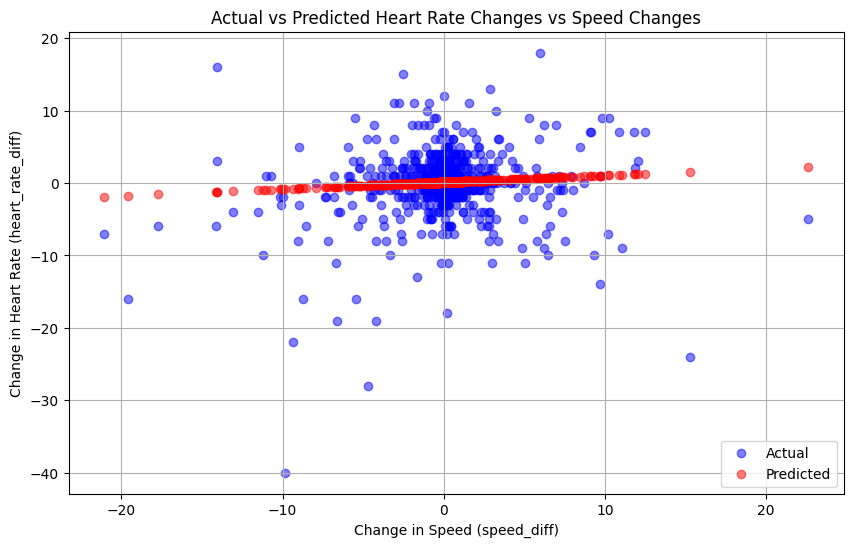

In [15]:
# Set up the scatter plot
plt.figure(figsize=(10, 6))
plt.title("Actual vs Predicted Heart Rate Changes vs Speed Changes")
plt.xlabel("Change in Speed (speed_diff)")  # Feature on the X-axis
plt.ylabel("Change in Heart Rate (heart_rate_diff)")  # Target on the Y-axis

# Scatter plot for actual values in blue
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Actual')

# Scatter plot for predicted values in red
plt.scatter(X_test, y_pred, color='red', alpha=0.5, label='Predicted')

# Add legend to differentiate actual and predicted points
plt.legend(loc='lower right')

# Show the plot
plt.grid(True)
plt.show()


In addition to examining model metrics and comparing actual vs. predicted values, we can also analyze the residuals. Residuals are the differences between the actual values and the predicted values. Plotting the residuals against the predicted values helps to diagnose the model's performance. Ideally, residuals should be randomly scattered around zero, indicating no systematic error in the predictions.

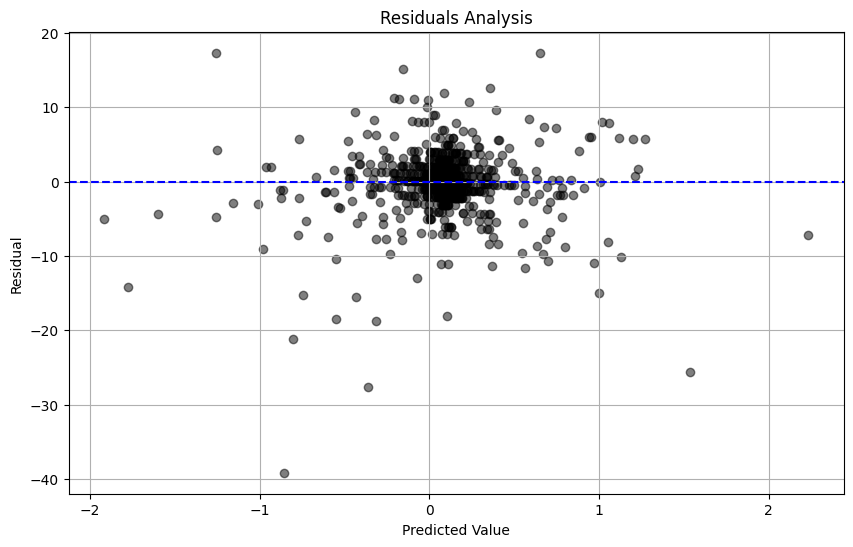

In [16]:
# Calculate residuals
residuals = y_test - y_pred

# Set up the residuals plot
plt.figure(figsize=(10, 6))
plt.title('Residuals Analysis')
plt.xlabel('Predicted Value')
plt.ylabel('Residual')
plt.scatter(y_pred, residuals, color='black', alpha=0.5)

# Add a horizontal line at zero to indicate where residuals should ideally cluster
plt.axhline(y=0, color='blue', linestyle='--')

# Display the plot
plt.grid(True)
plt.show()


## 4 Model Improvement with More Features (Multivariate Regression)

In this section, we aim to enhance our model by including an additional feature, `altitude_diff`, alongside `speed_diff`, to see if we can improve the prediction of `heart_rate_diff`. Using multiple features in a regression model is called Multivariate Regression and helps the model capture more complex relationships within the data.

- Features: 'Speed_diff', 'Altitude_diff'
- Target: 'Heart_rate_diff'

In [17]:
X_Features = ["speed_diff", "altitude_diff"] # Features to use as input for the model
Y_Features = ["heart_rate_diff"] # Features to predict
TEST_SIZE = 0.0001
RANDOM_STATE = 42

### 4.1 Check Correlation between Features

Before adding additional features to the model, it’s useful to understand the relationships between these features using a **correlation matrix**. This can reveal any linear relationships between variables, which might influence model performance.

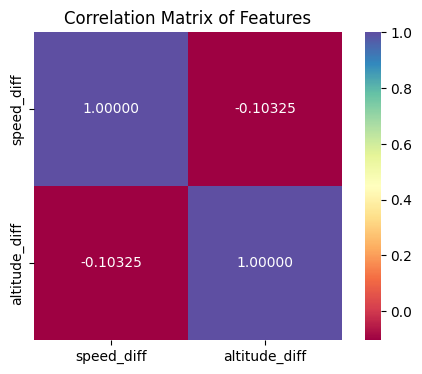

In [18]:
# Compute the correlation matrix
correlation_matrix = endomondo_df[X_Features].corr()

# Plot the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='Spectral', square=True, fmt='.5f')
plt.title('Correlation Matrix of Features')
plt.show()

The correlation value of `-0.10325` between `speed_diff` and `altitude_diff` is relatively low (weak correlation) and slightly negative.

- A correlation close to zero (whether positive or negative) indicates a weak linear relationship between the variables. In this case, `speed_diff and altitude_diff` are only weakly correlated with each other.

- The slight negative value means that, in general, when `altitude_diff increases`, `speed_diff` might decrease slightly, but this relationship is very weak. This could suggest that changes in altitude have a minor inverse effect on speed, which could be due to factors like increased effort required when going uphill (if altitude increases).

Since there is a weak correlation, this suggests that `speed_diff` and `altitude_diff` are mostly independent. Thus, including both features in the model is likely beneficial because they provide complementary information.


### 4.2 Split the Data into Training and Testing Sets

Now, we will split the data into training and testing sets. Using multiple features will allow the model to capture more complex patterns, potentially improving prediction accuracy.

In [19]:
# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(endomondo_df[X_Features],
                                                        endomondo_df[Y_Features],
                                                        test_size=TEST_SIZE,
                                                        random_state=RANDOM_STATE)

# Display the shapes of the resulting splits
print(f"Training set size: {X_train2.shape[0]} samples")
print(f"Test set size: {X_test2.shape[0]} samples")

Training set size: 9694530 samples
Test set size: 970 samples


### 4.3 Train a Linear Regression Model

With the expanded feature set, we’ll train a Linear Regression model using both `speed_diff` and `altitude_diff`.

In [20]:
# Initialize and train the Linear Regression model
model2 = LinearRegression()
model2.fit(X_train2, y_train2)

# Display the model coefficients and intercept
print("Model Coefficients:", ", ".join(map(lambda x: f"{x:.5f}", model2.coef_.flatten())))
print("Model Intercept:", f"{model2.intercept_[0]:.5f}")

Model Coefficients: 0.11247, 0.21427
Model Intercept: 0.08420


### 4.4 Make Predictions on the Test Set

We’ll use the trained model to make predictions on the test set.

In [21]:
# Make predictions on the test set
y_pred2 = model2.predict(X_test2)

# Display a sample of predictions vs actual values
comparison_df2 = pd.DataFrame({
    'Actual': y_test2.values.flatten(),
    'Predicted': y_pred2.flatten()
})
print("Sample of Predictions vs. Actual Values:")
print(comparison_df2.head())

Sample of Predictions vs. Actual Values:
   Actual  Predicted
0     1.0   0.093916
1     2.0   0.192007
2     3.0   0.140074
3     2.0   0.384180
4     0.0  -0.062180


### 4.5 Evaluate Model with MSE

Calculating the **Mean Squared Error (MSE)** will give an indication of the average squared difference between actual and predicted values, with lower values indicating better accuracy.

In [22]:
# Calculate the Mean Squared Error (MSE)
mse2 = mean_squared_error(y_test2, y_pred2)
print(f"Mean Squared Error (MSE): {mse2:.5f}")

Mean Squared Error (MSE): 14.69246


### 4.6 Evaluate Model with MAE

The **Mean Absolute Error (MAE)** provides an interpretable measure of the average absolute difference between actual and predicted values.

In [23]:
# Calculate the Mean Absolute Error (MAE)
mae2 = mean_absolute_error(y_test2, y_pred2)
print(f"Mean Absolute Error (MAE): {mae2:.5f}")

Mean Absolute Error (MAE): 2.18911


### Viualize Predictions

To visually compare the model's predicted values with the actual target values, we will plot a scatter plot with:

- X-axis: The input feature(s) used in the model (`speed_diff`).
- Y-axis: The target variable (`heart_rate_diff`).

For multivariate regression, we’ll focus on one of the input features for the X-axis to keep the visualization simple and clear. Here, we’ll use `speed_diff` for the X-axis, which was the primary feature, and plot both actual and predicted `heart_rate_diff` values on the Y-axis.

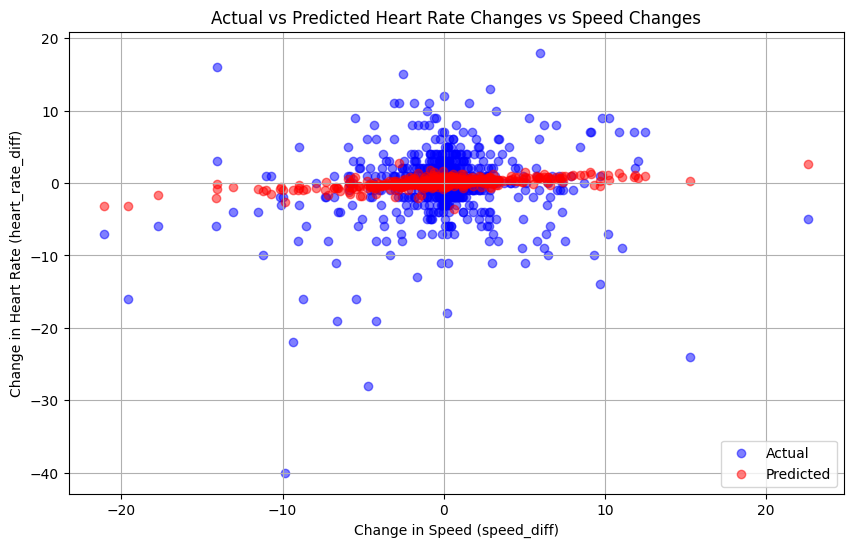

In [24]:
# Set up the scatter plot
plt.figure(figsize=(10, 6))
plt.title("Actual vs Predicted Heart Rate Changes vs Speed Changes")
plt.xlabel("Change in Speed (speed_diff)")  # Feature on the X-axis
plt.ylabel("Change in Heart Rate (heart_rate_diff)")  # Target on the Y-axis

# Scatter plot for actual values in blue
plt.scatter(X_test2['speed_diff'], y_test2, color='blue', alpha=0.5, label='Actual')

# Scatter plot for predicted values in red
plt.scatter(X_test2['speed_diff'], y_pred2, color='red', alpha=0.5, label='Predicted')

# Add legend to differentiate actual and predicted points
plt.legend(loc='lower right')

# Show the plot
plt.grid(True)
plt.show()


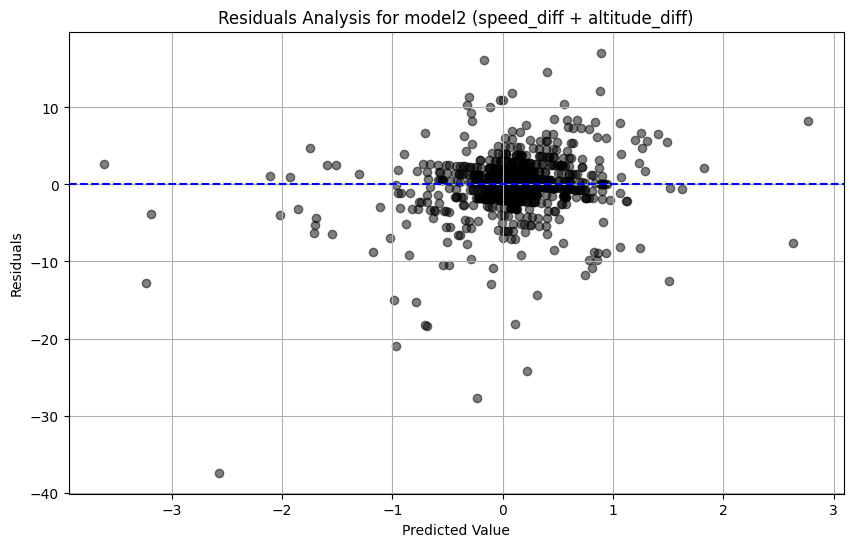

In [25]:
# Calculate residuals for model2 predictions
residuals2 = y_test2 - y_pred2

# Set up the residuals plot
plt.figure(figsize=(10, 6))
plt.title('Residuals Analysis for model2 (speed_diff + altitude_diff)')
plt.xlabel('Predicted Value')
plt.ylabel('Residuals')
plt.scatter(y_pred2, residuals2, color='black', alpha=0.5)

# Add a horizontal line at zero to indicate ideal residual alignment
plt.axhline(y=0, color='blue', linestyle='--')

# Display the plot
plt.grid(True)
plt.show()




**Blue Dots**: Represent the actual heart rate changes observed in the dataset

- The wide dispersion of these points indicates that heart rate changes vary significantly, showing that heart rate response is influenced by multiple factors and can fluctuate widely with changes in speed and altitude.

**Red Dots**: Represent the predicted heart rate changes by our models:

- `model1` (based only on `speed_diff`) provided a simpler linear pattern, which suggested underfitting as it struggled to capture the full variance in heart rate changes. It captured the general trend but was unable to account for more extreme fluctuations.

- `model2` (using both `speed_diff` and `altitude_diff`) shows an improvement, as the red points are more spread out compared to `model1`. This suggests that incorporating `altitude_diff` helps in capturing additional aspects of heart rate variability.

- However, despite this improvement, `model2` still underfits the data. The predicted points remain clustered near zero and fail to account for the more extreme values observed in the actual data. This indicates that while altitude adds some predictive power, it may not be sufficient on its own, and further feature engineering or a more complex model may be needed to fully capture the observed variability.


While adding `altitude_diff` improves the model’s alignment with actual data points, the limited spread of predictions suggests that heart rate changes are influenced by other unaccounted factors. To achieve a more accurate prediction, additional features or a more sophisticated model might be necessary.



## 5 Model Comparison

Here, we will compare the performance of two regression models: Linear Regression and Multivariate Regression. We’ll evaluate each model using Mean Squared Error (MSE), Mean Absolute Error (MAE), and scatter plots in previous steps to understand how well each model captures the relationship between the features and target variable.

- Model 1: Predicts `heart_rate_diff` based solely on `speed_diff`.

  - **MSE**: 15.507
  - **MAE**: 2.228
  - **Interpretation**: Model 1, using only `speed_diff`, provides a baseline for predictive accuracy. However, its limited scope may result in underfitting, as it does not account for other influencing factors.

- Model 2: Predicts `heart_rate_diff` using both `speed_diff` and `altitude_diff`.

  - **MSE**: 14.692
  - **MAE**: 2.189
  - **Interpretation**: Model 2, which includes `altitude_diff`, shows a reduction in both MSE and MAE compared to Model 1. This improvement suggests that `altitude_diff` contributes additional information that enhances the model’s predictive accuracy.

The lower MSE and MAE values of Model 2 indicate it has better predictive accuracy than Model 1. This improvement can likely be attributed to the inclusion of `altitude_diff`, which may capture additional variability in `heart_rate_diff` that `speed_diff` alone does not.

On the other hand, the scatter plot reveals a non-linear pattern in the relationship between `speed_diff` and `heart_rate_diff`, suggesting that a simple linear model might not fully capture this complexity. Adding `altitude_diff` for multiple linear regression does improve the model but may still fall short if the relationship is significantly non-linear.